In [13]:
import random
from helpers import *
# random.seed(6)
# np.random.seed(6)
i=0
df = pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/20Xfull'+str(i+1)+'.csv')
df =df.drop('Unnamed: 0',axis=1)
Z = np.array(df,dtype = 'float64')

# redefine Z to be all the other columns except the last one
n,p= Z.shape
Znorm = normalize_columns(Z)
mu0 = np.mean(Znorm, axis=0)
Sigma0 = np.cov(Znorm.T)
#Gamma0 = np.zeros((p, p))
Gamma0 =np.random.normal(0.0001,0.001,(p,p))
#find best sr
# St = sr_best(Znorm,lambda_val = 0.01, sigma = 500, T = 10000)
# print(St)
St=np.array([ 0, 4, 6, 9, 22])
Z0 = Z[:,St]
Gamma0[St] = np.linalg.inv(Z0.T@Z0)@Z0.T@Z

Gamma = cp.Variable((p,p))
Gamma.value = Gamma0
############ Sigma 1 ###################
Sigma = np.cov((Z-Z@Gamma.value).T)
############ Sigma 2 ###################
# Sigma = (Z-Z@Gamma0).T@(Z-Z@Gamma0)/n
############ Sigma 3 ###################
# k=5
# U, S, V =  np.linalg.svd(Z)
# Z_approx = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
# # Calculate the difference between the rank-k approximation and the actual values
# difference = Z - Z_approx
# Sigma = np.cov(np.transpose(difference), rowvar=True)  
# Sigma_inverse = np.linalg.inv(covariance_matrix) / 10**17

S,U=np.linalg.eig(Sigma)
Sigma_half_inv =U@np.diag(np.sqrt(1/S))@U.T/ 10**13

for i in range(1):
    objective = cp.Minimize(cp.norm( Sigma_half_inv @ Z.T - Sigma_half_inv @ Gamma.T @ Z.T  , 'fro')**2)
    # Define the constraint
    constraints = [
        cp.sum(cp.norm(Gamma, 2, axis=1))<=5
    ]
    # Define the optimization problem
    problem = cp.Problem(objective, constraints)
    # Solve the optimization problem
    result = problem.solve()

St0= chosen_set_with_press(Gamma.value,5,Znorm)[0]
print(np.linalg.norm(Gamma.value, axis=1))
print(St0,'sr',sr(np.linalg.solve(Sigma0[St0][:, St0], mu0[St0]), mu0[St0], Sigma0[St0][:, St0]) )


[8.74469887e-05 1.45996978e-05 2.33585915e-05 1.56420666e-05
 4.01194894e-05 5.61678507e-05 1.66474207e-05 7.15353929e-08
 1.61434127e-05 1.27314027e-04 8.16909296e-06 2.34963023e-05
 1.70911911e-05 1.32638001e-05 6.09953854e-06 1.55389300e-05
 2.05690640e-06 1.44902626e-05 7.71637947e-06 1.55911962e-05
 5.36333600e-06 1.10601985e-05 6.74591805e-05 1.06074225e-05
 5.29169198e-06]
[9, 0, 22, 5, 4] sr 0.10560294716641169


In [16]:
from helpers import  *

def estimate_subset(k, Z, T, sigma, lambd):
    n, p = Z.shape
    Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

    # Calculate sample mean and sample covariance matrix
    alpha_hat = np.mean(Z - Mh, axis=0)
    Sigma = np.cov((Z - Mh).T)
    S,U=np.linalg.eig(Sigma)
    S = np.abs(S)
    Sigma_half_inv =U@np.diag(np.sqrt(1/S))@U.T
    # Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
    indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:2*k]
    St = set(indices)
    
    SRwPenalty = np.zeros(T)
    #record the subset selection in each MH update
    Sseq = np.zeros((p, T))
    for t in range(T):
        j = np.random.randint(p)  # Generate a random index
        # Create new subset S_new by adding or removing j
        Z_St = Z[:, list(St)]
        if j in St:
            
            S_new = St - {j}
           
        else:
            S_new = St | {j}
           
        Z_S_new = Z[:, list(S_new)]    
        Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new) @ Z_S_new.T  @ Z 
        
   
        # Calculate the new Theta and acceptance probability
      
        Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
        acceptance_prob = np.exp(
            -sigma * np.linalg.norm(( Sigma_half_inv  @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
            - lambd * len(S_new)
            +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
            + lambd * len(St)
        )
       
        # Set the new subset S_t+1 with probability according to acceptance probability
        if np.random.rand() > acceptance_prob:
            St = S_new
            
        Sseq[list(S_new), t] = 1

        #record Sharpe ratio + penalty
        SRwPenalty[t] = - sigma * np.linalg.norm(( Sigma_half_inv  @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2 - lambd * len(S_new)
        
    import matplotlib.pyplot as plt
    #Plots
    plt.plot(SRwPenalty/10**20)
    plt.plot(np.sum(Sseq, axis=0))    
    sridx = np.argmax(SRwPenalty)
    #Find the indices of selected factors
    Sopt = np.where(Sseq[:, sridx])[0]
    
    return Sopt

[ 0  1  2  3  4  6  8 18 19 22 23]


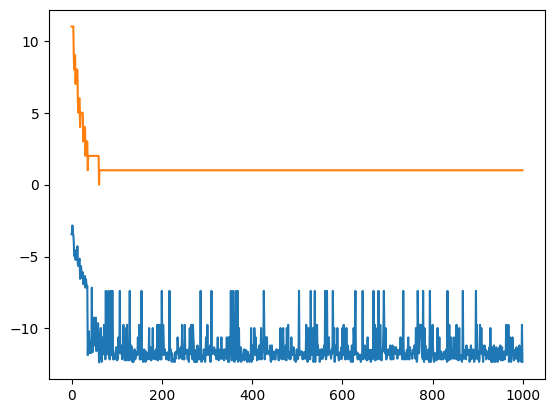

In [17]:
i=0
df = pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/20Xfull'+str(i+1)+'.csv')
df =df.drop('Unnamed: 0',axis=1)
Z = np.array(df,dtype = 'float64')
print(estimate_subset(5, Z, 1000, 10, 10))